In [1]:
from catboost import CatBoostClassifier
import catboost as catboost
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from random import sample
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, r2_score, roc_auc_score, roc_curve, cohen_kappa_score, brier_score_loss
from sklearn.metrics import matthews_corrcoef
#import shap

In [2]:
data = pd.read_csv("dat_15-09-2022_morgan_chiral_1024FP.csv")
#data = pd.read_csv("dat_mol_desc.csv")
#data = pd.read_csv("15-09-2022_dat_Substructure.csv")
#data = pd.read_csv("15-09-2022_dat_PubChem.csv")
#data = pd.read_csv("15-09-2022_dat_MACCS.csv")
#data = pd.read_csv("15-09-2022_dat_KlekotaRoth.csv")
#data = pd.read_csv("15-09-2022_dat_CDKgraph.csv")
#data = pd.read_csv("15-09-2022_dat_EState.csv")
#data = pd.read_csv("15-09-2022_dat_AtomPairs2D.csv")

In [3]:
df = pd.DataFrame(data)
df.reset_index(drop=True, inplace=True)
#df

In [4]:
y= df.Target
X=df.drop('Target', axis=1)

In [5]:
cat_features=list(range(0,X.shape[1]))
#print(cat_features)

In [6]:
df.Target.value_counts()

0    1109
1    1102
Name: Target, dtype: int64

In [7]:
y_train = df.Target
x_train = df.drop('Target', axis=1)

Split the dataset

In [8]:
#x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=1, stratify = y)

In [9]:
#transpose matrices
x_train = x_train.T
y_train = y_train.T

In [10]:
y_train.value_counts()

0    1109
1    1102
Name: Target, dtype: int64

In [11]:
#Read the validation set
v_test_data = pd.read_csv("val_15-09-2022_morgan_chiral_1024FP.csv")
#v_test_data = pd.read_csv("val_mol_desc.csv")
#v_test_data = pd.read_csv("15-09-2022_val_Substructure.csv")
#v_test_data = pd.read_csv("15-09-2022_val_PubChem.csv")
#v_test_data = pd.read_csv("15-09-2022_val_MACCS.csv")
#v_test_data = pd.read_csv("15-09-2022_val_KlekotaRoth.csv")
#v_test_data = pd.read_csv("15-09-2022_val_CDKgraph.csv")
#v_test_data = pd.read_csv("15-09-2022_val_EState.csv")
#v_test_data = pd.read_csv("15-09-2022_val_AtomPairs2D.csv")
v_test_data = pd.DataFrame(v_test_data)
v_test_data.shape

(367, 1025)

In [12]:
Y_v_test_data = v_test_data.Target
X_v_test_data = v_test_data.drop('Target', axis=1)

In [13]:
#Without hyperparameters
#cb = catboost.CatBoostClassifier()
#############################################################
#from sklearn.ensemble import RandomForestClassifier
#cb = RandomForestClassifier()
#############################################################
#import xgboost as xgb
#cb = xgb.XGBRFClassifier()
#############################################################
#from sklearn.svm import SVC
#cb = SVC(kernel='rbf',probability=True)
#############################################################
#cb = xgb.XGBClassifier()
#############################################################
#cb.fit(x_train.T, y_train.T)
#Model building
#v_predictions = cb.predict(X_v_test_data)
#acc_train=cb.score(x_train.T,y_train.T)*100
#v_acc_test = cb.score(X_v_test_data, Y_v_test_data)*100
#print("Training accuracy without hyperparameters:",acc_train)
#print("Validation accuracy without hyperparameters:",v_acc_test)

In [14]:
#cb = catboost.CatBoostClassifier()
#With hyperparameters
#Parameters for 1024_2048_fp
cb = catboost.CatBoostClassifier(
    learning_rate = 0.0001,
    iterations=2000,
    random_strength = 42,
    depth = 12,
    leaf_estimation_iterations=12
)
################################################################################################################
#Parameters for desc
#cb = catboost.CatBoostClassifier(
#    learning_rate = 0.0001,
#    iterations=3000,
#    random_strength = 42,
#    depth = 10,
#    leaf_estimation_iterations=3
#)
cb.fit(x_train.T, y_train.T, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [15]:
v_predictions = cb.predict(X_v_test_data)
acc_train=cb.score(x_train.T,y_train.T)*100
v_acc_test = cb.score(X_v_test_data, Y_v_test_data)*100
print("Training accuracy with hyperparameters:",acc_train)
print("Validation accuracy with hyperparameters:",v_acc_test)

Training accuracy with hyperparameters: 85.70782451379466
Validation accuracy with hyperparameters: 68.66485013623979


In [16]:
from sklearn.metrics import matthews_corrcoef
print('Accuracy:%0.3f'% v_acc_test)
tn, fp, fn, tp = confusion_matrix(Y_v_test_data, v_predictions).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity:%0.3f'% sensitivity)
print('Specificity:%0.3f'% specificity)
ba = 0.5 * (sensitivity + specificity)
print('Balance accuracy:%0.3f'% ba)
mcc = matthews_corrcoef(Y_v_test_data, v_predictions)
#mcc = matthews_corrcoef(Y_test_data, v_predictions)
print('MCC: %0.3f'% mcc)
r_auc_score = roc_auc_score(Y_v_test_data, v_predictions)
#r_auc_score = roc_auc_score(Y_test_data, v_predictions)
print('AUC: %0.3f' % r_auc_score)
bloss = brier_score_loss(Y_v_test_data, v_predictions)
#bloss = brier_score_loss(Y_test_data, v_predictions)
print('Brier_loss: %0.3f' % bloss)
FPR = fp/(fp+tn)
FNR = fn/(tp+fn)
Precision = tp/(tp+fp)
Recall = tp/(tp+fn)
print('False Postive rate: %0.3f' %FPR)
print('False Negative rate: %0.3f' %FNR)
print('Precision: %0.3f' %Precision)
print('Recall: %0.3f' %Recall)
f1=2*((Precision*Recall)/(Precision+Recall))
print('F1: %0.3f' %f1)
#kappa = cohen_kappa_score(Y_test_data, v_predictions)
kappa = cohen_kappa_score(Y_v_test_data, v_predictions)
print('Kappa: %0.3f' %kappa)

Accuracy:68.665
Sensitivity:0.588
Specificity:0.734
Balance accuracy:0.661
MCC: 0.312
AUC: 0.661
Brier_loss: 0.313
False Postive rate: 0.266
False Negative rate: 0.412
Precision: 0.515
Recall: 0.588
F1: 0.549
Kappa: 0.311


In [17]:
cf =(confusion_matrix(Y_v_test_data, v_predictions))
print(classification_report(Y_v_test_data, v_predictions))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76       248
           1       0.51      0.59      0.55       119

    accuracy                           0.69       367
   macro avg       0.65      0.66      0.65       367
weighted avg       0.70      0.69      0.69       367



<AxesSubplot:xlabel='Predicted Value', ylabel='True Value'>

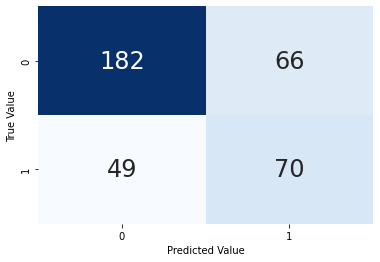

In [18]:
cf_plt =sns.heatmap(cf,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
cf_plt.set(xlabel = "Predicted Value", ylabel ="True Value")
cf_plt

In [20]:
r_probs = [0 for _ in range(len(Y_v_test_data))]
cb_prob = cb.predict_proba(X_v_test_data)
cb_prob = cb_prob[:,1]
#cb_prob

In [21]:
#prediction_val=cb.predict(X_v_test_data)

In [22]:
#prediction_val=pd.DataFrame(prediction_val)

In [23]:
#prediction_val.to_csv("label_val_1024_CB.csv")

In [24]:
r_auc_score = roc_auc_score(Y_v_test_data, cb_prob)
r_auc_score_1 = roc_auc_score(Y_v_test_data,r_probs)
print(r_auc_score)
fpr, tpr, _ = roc_curve(Y_v_test_data, cb_prob)
rfpr, rtpr, _ = roc_curve(Y_v_test_data, r_probs)

0.7209609650311737


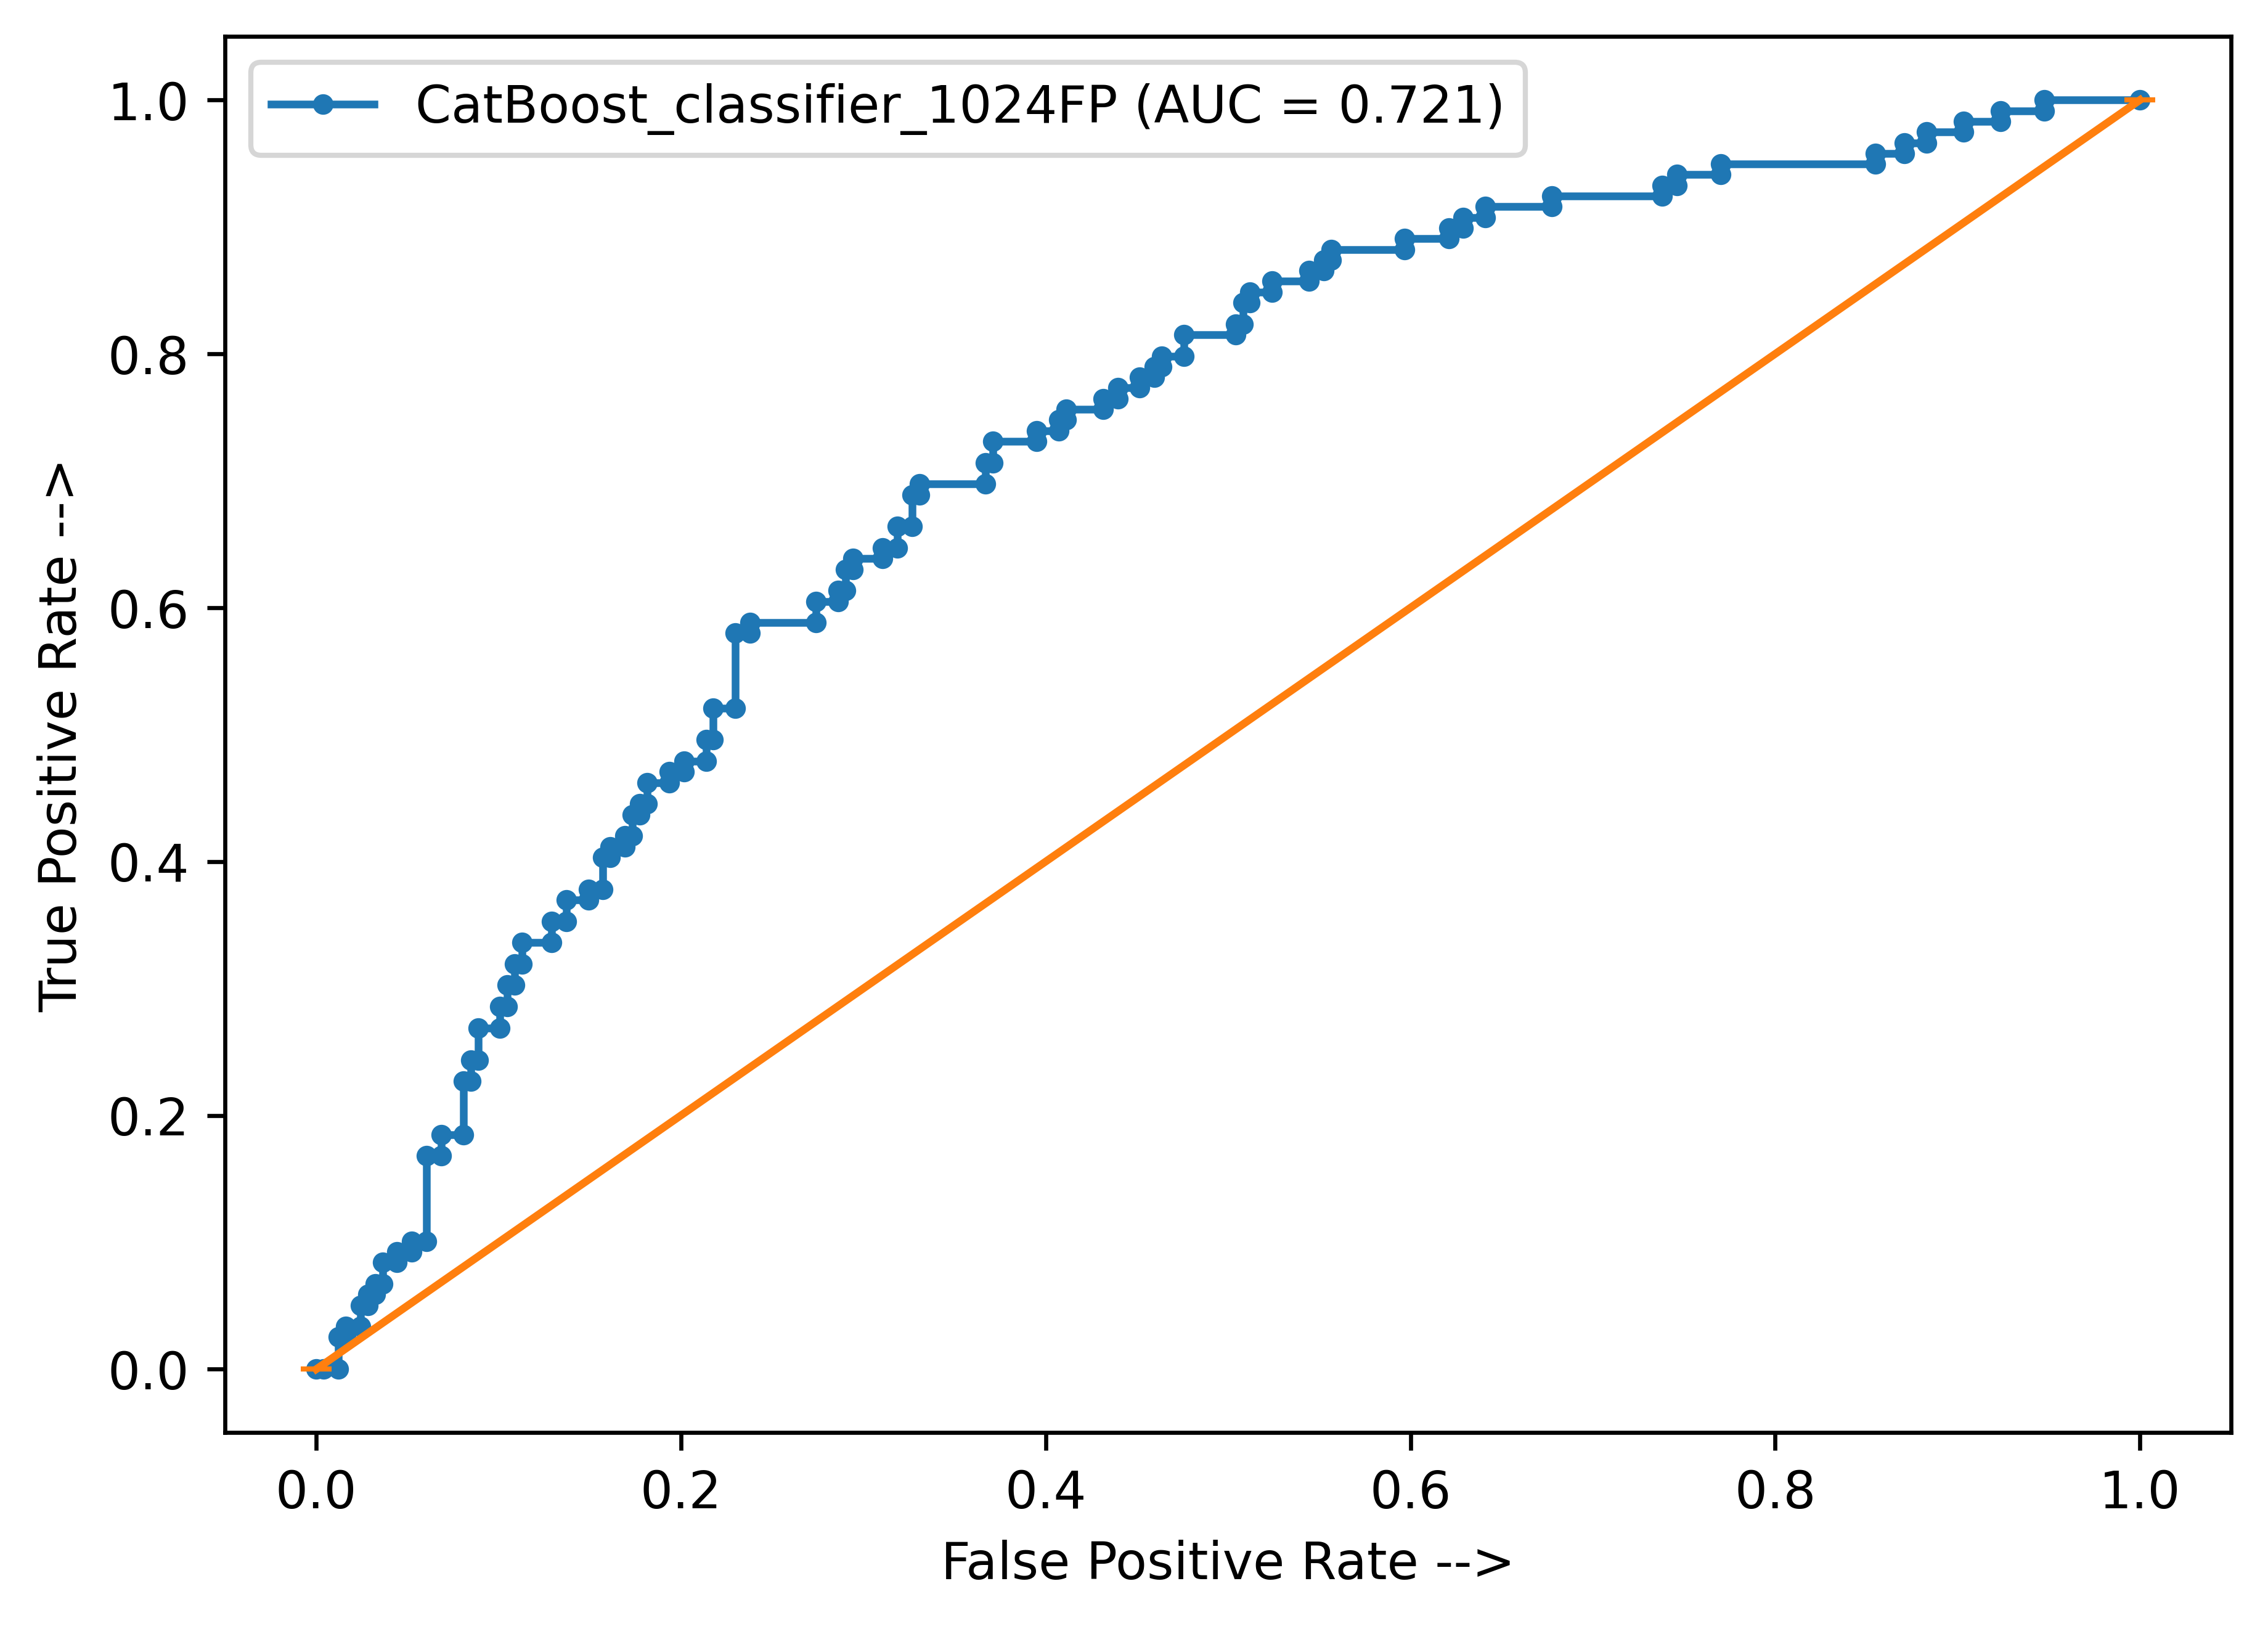

In [25]:
plt.figure(figsize=(7, 5), dpi=600)
plt.plot(fpr, tpr, marker='.', label='CatBoost_classifier_1024FP (AUC = %0.3f)' % r_auc_score)
plt.plot(rfpr, rtpr, marker='_' % r_auc_score_1)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()
#plt.savefig('CB_AUC_1024.png', dpi=600, bbox_inches='tight')

In [26]:
#Read external set
#external_data = pd.read_csv("cyclic_ind_16-09-2022_morgan_chiral_2048FP.csv")
#data_for_screening = pd.DataFrame(external_data)
#data_for_screening

In [27]:
#test external data
#test_prob = cb.predict_proba(data_for_screening)
#test_prob_F = pd.DataFrame(test_prob)
#test_prob_F.to_csv('cyclic_ind_CB2048_probability_FP.csv')

## Cross validation AUC 

In [28]:
from sklearn.metrics import RocCurveDisplay

In [29]:
from scipy import interp
from sklearn.metrics import roc_curve,auc
cv = StratifiedKFold(n_splits=10,shuffle=False)

0:	learn: 0.6931406	total: 283ms	remaining: 9m 26s
1:	learn: 0.6931228	total: 574ms	remaining: 9m 32s
2:	learn: 0.6931120	total: 858ms	remaining: 9m 31s
3:	learn: 0.6931038	total: 1.17s	remaining: 9m 45s
4:	learn: 0.6930953	total: 1.47s	remaining: 9m 45s
5:	learn: 0.6930884	total: 1.76s	remaining: 9m 45s
6:	learn: 0.6930764	total: 2.07s	remaining: 9m 50s
7:	learn: 0.6930701	total: 2.36s	remaining: 9m 47s
8:	learn: 0.6930647	total: 2.66s	remaining: 9m 48s
9:	learn: 0.6930562	total: 2.98s	remaining: 9m 52s
10:	learn: 0.6930494	total: 3.29s	remaining: 9m 54s
11:	learn: 0.6930421	total: 3.58s	remaining: 9m 53s
12:	learn: 0.6930364	total: 3.87s	remaining: 9m 52s
13:	learn: 0.6930299	total: 4.17s	remaining: 9m 51s
14:	learn: 0.6930218	total: 4.47s	remaining: 9m 51s
15:	learn: 0.6930110	total: 4.75s	remaining: 9m 48s
16:	learn: 0.6930031	total: 5.04s	remaining: 9m 47s
17:	learn: 0.6929947	total: 5.34s	remaining: 9m 47s
18:	learn: 0.6929875	total: 5.63s	remaining: 9m 47s
19:	learn: 0.6929761	t

/tmp/ipykernel_208977/2921947858.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0:	learn: 0.6931391	total: 331ms	remaining: 11m 1s
1:	learn: 0.6931315	total: 694ms	remaining: 11m 33s
2:	learn: 0.6931288	total: 864ms	remaining: 9m 34s
3:	learn: 0.6931198	total: 1.22s	remaining: 10m 10s
4:	learn: 0.6931047	total: 1.53s	remaining: 10m 12s
5:	learn: 0.6930946	total: 1.86s	remaining: 10m 17s
6:	learn: 0.6930876	total: 2.16s	remaining: 10m 15s
7:	learn: 0.6930770	total: 2.48s	remaining: 10m 16s
8:	learn: 0.6930725	total: 2.55s	remaining: 9m 24s
9:	learn: 0.6930638	total: 2.86s	remaining: 9m 29s
10:	learn: 0.6930548	total: 3.21s	remaining: 9m 40s
11:	learn: 0.6930450	total: 3.57s	remaining: 9m 51s
12:	learn: 0.6930338	total: 3.9s	remaining: 9m 55s
13:	learn: 0.6930258	total: 4.21s	remaining: 9m 56s
14:	learn: 0.6930204	total: 4.49s	remaining: 9m 54s
15:	learn: 0.6930119	total: 4.8s	remaining: 9m 55s
16:	learn: 0.6930013	total: 5.14s	remaining: 9m 59s
17:	learn: 0.6929941	total: 5.51s	remaining: 10m 6s
18:	learn: 0.6929874	total: 5.85s	remaining: 10m 10s
19:	learn: 0.6929

/tmp/ipykernel_208977/2921947858.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0:	learn: 0.6931404	total: 272ms	remaining: 9m 4s
1:	learn: 0.6931217	total: 554ms	remaining: 9m 13s
2:	learn: 0.6931112	total: 840ms	remaining: 9m 19s
3:	learn: 0.6931029	total: 1.13s	remaining: 9m 23s
4:	learn: 0.6930940	total: 1.42s	remaining: 9m 26s
5:	learn: 0.6930868	total: 1.7s	remaining: 9m 25s
6:	learn: 0.6930742	total: 1.99s	remaining: 9m 27s
7:	learn: 0.6930677	total: 2.29s	remaining: 9m 29s
8:	learn: 0.6930614	total: 2.56s	remaining: 9m 26s
9:	learn: 0.6930532	total: 2.85s	remaining: 9m 26s
10:	learn: 0.6930458	total: 3.12s	remaining: 9m 24s
11:	learn: 0.6930386	total: 3.42s	remaining: 9m 25s
12:	learn: 0.6930327	total: 3.7s	remaining: 9m 26s
13:	learn: 0.6930267	total: 3.99s	remaining: 9m 26s
14:	learn: 0.6930185	total: 4.28s	remaining: 9m 26s
15:	learn: 0.6930072	total: 4.57s	remaining: 9m 27s
16:	learn: 0.6930000	total: 4.87s	remaining: 9m 27s
17:	learn: 0.6929912	total: 5.16s	remaining: 9m 27s
18:	learn: 0.6929836	total: 5.44s	remaining: 9m 27s
19:	learn: 0.6929735	tota

/tmp/ipykernel_208977/2921947858.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0:	learn: 0.6931412	total: 395ms	remaining: 13m 9s
1:	learn: 0.6931235	total: 775ms	remaining: 12m 54s
2:	learn: 0.6931121	total: 1.17s	remaining: 12m 57s
3:	learn: 0.6931034	total: 1.55s	remaining: 12m 51s
4:	learn: 0.6930948	total: 1.94s	remaining: 12m 55s
5:	learn: 0.6930870	total: 2.34s	remaining: 12m 57s
6:	learn: 0.6930747	total: 2.77s	remaining: 13m 8s
7:	learn: 0.6930680	total: 3.13s	remaining: 12m 59s
8:	learn: 0.6930620	total: 3.5s	remaining: 12m 54s
9:	learn: 0.6930541	total: 3.88s	remaining: 12m 52s
10:	learn: 0.6930463	total: 4.27s	remaining: 12m 52s
11:	learn: 0.6930388	total: 4.67s	remaining: 12m 53s
12:	learn: 0.6930333	total: 5.05s	remaining: 12m 52s
13:	learn: 0.6930270	total: 5.43s	remaining: 12m 50s
14:	learn: 0.6930190	total: 5.8s	remaining: 12m 47s
15:	learn: 0.6930074	total: 6.18s	remaining: 12m 46s
16:	learn: 0.6929994	total: 6.54s	remaining: 12m 42s
17:	learn: 0.6929908	total: 6.92s	remaining: 12m 42s
18:	learn: 0.6929840	total: 7.28s	remaining: 12m 39s
19:	lea

/tmp/ipykernel_208977/2921947858.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0:	learn: 0.6931386	total: 330ms	remaining: 10m 59s
1:	learn: 0.6931207	total: 650ms	remaining: 10m 49s
2:	learn: 0.6931097	total: 949ms	remaining: 10m 31s
3:	learn: 0.6931025	total: 1.27s	remaining: 10m 35s
4:	learn: 0.6930936	total: 1.59s	remaining: 10m 34s
5:	learn: 0.6930861	total: 1.88s	remaining: 10m 25s
6:	learn: 0.6930730	total: 2.21s	remaining: 10m 30s
7:	learn: 0.6930660	total: 2.53s	remaining: 10m 29s
8:	learn: 0.6930603	total: 2.84s	remaining: 10m 27s
9:	learn: 0.6930519	total: 3.19s	remaining: 10m 35s
10:	learn: 0.6930444	total: 3.52s	remaining: 10m 35s
11:	learn: 0.6930382	total: 3.84s	remaining: 10m 35s
12:	learn: 0.6930327	total: 4.14s	remaining: 10m 33s
13:	learn: 0.6930264	total: 4.51s	remaining: 10m 40s
14:	learn: 0.6930180	total: 4.87s	remaining: 10m 44s
15:	learn: 0.6930061	total: 5.21s	remaining: 10m 45s
16:	learn: 0.6929982	total: 5.52s	remaining: 10m 43s
17:	learn: 0.6929893	total: 5.85s	remaining: 10m 44s
18:	learn: 0.6929820	total: 6.16s	remaining: 10m 41s
19:

/tmp/ipykernel_208977/2921947858.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0:	learn: 0.6931409	total: 376ms	remaining: 12m 31s
1:	learn: 0.6931233	total: 797ms	remaining: 13m 16s
2:	learn: 0.6931124	total: 1.18s	remaining: 13m 6s
3:	learn: 0.6931037	total: 1.57s	remaining: 13m 5s
4:	learn: 0.6930947	total: 1.97s	remaining: 13m 7s
5:	learn: 0.6930882	total: 2.35s	remaining: 12m 59s
6:	learn: 0.6930755	total: 2.72s	remaining: 12m 54s
7:	learn: 0.6930694	total: 3.11s	remaining: 12m 54s
8:	learn: 0.6930626	total: 3.51s	remaining: 12m 56s
9:	learn: 0.6930543	total: 3.94s	remaining: 13m 4s
10:	learn: 0.6930471	total: 4.3s	remaining: 12m 58s
11:	learn: 0.6930395	total: 4.68s	remaining: 12m 55s
12:	learn: 0.6930338	total: 5.03s	remaining: 12m 49s
13:	learn: 0.6930272	total: 5.4s	remaining: 12m 46s
14:	learn: 0.6930187	total: 5.76s	remaining: 12m 42s
15:	learn: 0.6930079	total: 6.12s	remaining: 12m 39s
16:	learn: 0.6929997	total: 6.49s	remaining: 12m 36s
17:	learn: 0.6929902	total: 6.86s	remaining: 12m 35s
18:	learn: 0.6929829	total: 7.24s	remaining: 12m 34s
19:	learn

/tmp/ipykernel_208977/2921947858.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0:	learn: 0.6931415	total: 449ms	remaining: 14m 56s
1:	learn: 0.6931292	total: 861ms	remaining: 14m 19s
2:	learn: 0.6931238	total: 1.07s	remaining: 11m 52s
3:	learn: 0.6931155	total: 1.47s	remaining: 12m 11s
4:	learn: 0.6930959	total: 1.86s	remaining: 12m 22s
5:	learn: 0.6930887	total: 2.26s	remaining: 12m 30s
6:	learn: 0.6930799	total: 2.65s	remaining: 12m 35s
7:	learn: 0.6930727	total: 3.06s	remaining: 12m 41s
8:	learn: 0.6930673	total: 3.14s	remaining: 11m 35s
9:	learn: 0.6930585	total: 3.55s	remaining: 11m 46s
10:	learn: 0.6930484	total: 3.94s	remaining: 11m 53s
11:	learn: 0.6930430	total: 4.38s	remaining: 12m 5s
12:	learn: 0.6930333	total: 4.76s	remaining: 12m 7s
13:	learn: 0.6930262	total: 5.14s	remaining: 12m 9s
14:	learn: 0.6930167	total: 5.53s	remaining: 12m 11s
15:	learn: 0.6930030	total: 5.91s	remaining: 12m 12s
16:	learn: 0.6929948	total: 6.28s	remaining: 12m 12s
17:	learn: 0.6929870	total: 6.65s	remaining: 12m 12s
18:	learn: 0.6929772	total: 7.03s	remaining: 12m 12s
19:	le

/tmp/ipykernel_208977/2921947858.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0:	learn: 0.6931405	total: 395ms	remaining: 13m 10s
1:	learn: 0.6931210	total: 795ms	remaining: 13m 13s
2:	learn: 0.6931113	total: 1.19s	remaining: 13m 11s
3:	learn: 0.6931023	total: 1.57s	remaining: 13m 2s
4:	learn: 0.6930943	total: 1.96s	remaining: 13m 1s
5:	learn: 0.6930869	total: 2.34s	remaining: 12m 58s
6:	learn: 0.6930737	total: 2.73s	remaining: 12m 57s
7:	learn: 0.6930664	total: 3.12s	remaining: 12m 57s
8:	learn: 0.6930604	total: 3.51s	remaining: 12m 57s
9:	learn: 0.6930521	total: 3.89s	remaining: 12m 53s
10:	learn: 0.6930455	total: 4.26s	remaining: 12m 50s
11:	learn: 0.6930382	total: 4.64s	remaining: 12m 49s
12:	learn: 0.6930328	total: 5.02s	remaining: 12m 46s
13:	learn: 0.6930263	total: 5.41s	remaining: 12m 48s
14:	learn: 0.6930178	total: 5.8s	remaining: 12m 47s
15:	learn: 0.6930059	total: 6.2s	remaining: 12m 48s
16:	learn: 0.6929981	total: 6.57s	remaining: 12m 46s
17:	learn: 0.6929890	total: 6.98s	remaining: 12m 48s
18:	learn: 0.6929819	total: 7.38s	remaining: 12m 49s
19:	lea

/tmp/ipykernel_208977/2921947858.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0:	learn: 0.6931371	total: 390ms	remaining: 12m 59s
1:	learn: 0.6931292	total: 762ms	remaining: 12m 41s
2:	learn: 0.6931211	total: 982ms	remaining: 10m 53s
3:	learn: 0.6931164	total: 1.37s	remaining: 11m 23s
4:	learn: 0.6931015	total: 1.79s	remaining: 11m 54s
5:	learn: 0.6930939	total: 2.18s	remaining: 12m 3s
6:	learn: 0.6930882	total: 2.59s	remaining: 12m 17s
7:	learn: 0.6930800	total: 2.98s	remaining: 12m 22s
8:	learn: 0.6930761	total: 3.03s	remaining: 11m 10s
9:	learn: 0.6930697	total: 3.42s	remaining: 11m 21s
10:	learn: 0.6930605	total: 3.79s	remaining: 11m 24s
11:	learn: 0.6930507	total: 4.18s	remaining: 11m 33s
12:	learn: 0.6930420	total: 4.55s	remaining: 11m 35s
13:	learn: 0.6930330	total: 4.92s	remaining: 11m 37s
14:	learn: 0.6930261	total: 5.28s	remaining: 11m 39s
15:	learn: 0.6930261	total: 5.29s	remaining: 10m 55s
16:	learn: 0.6930175	total: 5.65s	remaining: 10m 58s
17:	learn: 0.6930110	total: 6.01s	remaining: 11m 2s
18:	learn: 0.6930014	total: 6.39s	remaining: 11m 6s
19:	le

/tmp/ipykernel_208977/2921947858.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0:	learn: 0.6931389	total: 388ms	remaining: 12m 55s
1:	learn: 0.6931218	total: 775ms	remaining: 12m 53s
2:	learn: 0.6931112	total: 1.15s	remaining: 12m 45s
3:	learn: 0.6931024	total: 1.53s	remaining: 12m 43s
4:	learn: 0.6930929	total: 1.93s	remaining: 12m 50s
5:	learn: 0.6930863	total: 2.31s	remaining: 12m 47s
6:	learn: 0.6930741	total: 2.69s	remaining: 12m 47s
7:	learn: 0.6930676	total: 3.07s	remaining: 12m 43s
8:	learn: 0.6930618	total: 3.45s	remaining: 12m 43s
9:	learn: 0.6930536	total: 3.82s	remaining: 12m 39s
10:	learn: 0.6930470	total: 4.2s	remaining: 12m 38s
11:	learn: 0.6930397	total: 4.57s	remaining: 12m 36s
12:	learn: 0.6930334	total: 4.93s	remaining: 12m 34s
13:	learn: 0.6930271	total: 5.31s	remaining: 12m 33s
14:	learn: 0.6930183	total: 5.71s	remaining: 12m 35s
15:	learn: 0.6930065	total: 6.11s	remaining: 12m 38s
16:	learn: 0.6929994	total: 6.5s	remaining: 12m 38s
17:	learn: 0.6929908	total: 6.9s	remaining: 12m 39s
18:	learn: 0.6929834	total: 7.26s	remaining: 12m 37s
19:	le

/tmp/ipykernel_208977/2921947858.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


<Figure size 4200x3000 with 0 Axes>

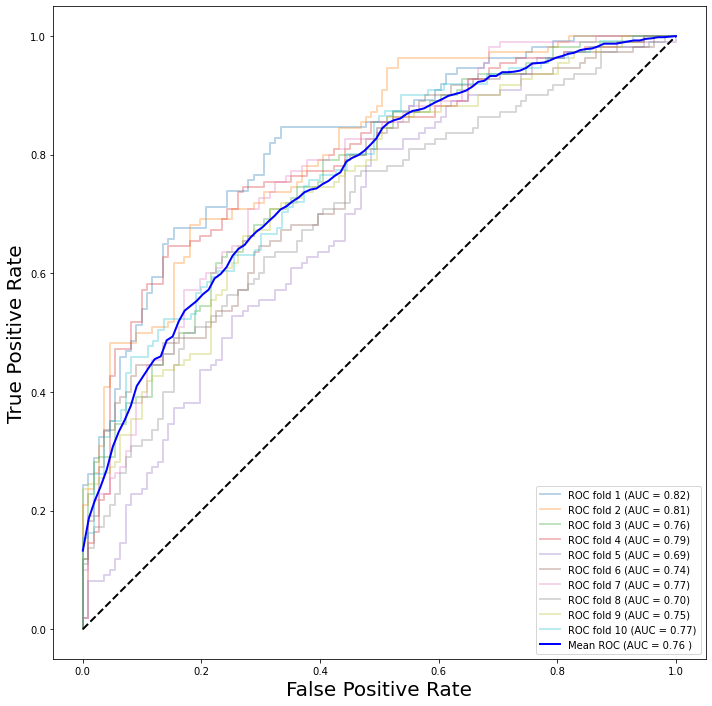

In [30]:
# plot k fold ROC
plt.figure(figsize=(7, 5), dpi=600)
x_train = x_train.T
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(x_train,y_train):
    prediction = cb.fit(x_train.iloc[train],y_train.iloc[train]).predict_proba(x_train.iloc[test])
    fpr, tpr, t = roc_curve(y_train.iloc[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.legend(loc="lower right")
plt.show()
#plt.savefig('CrossVal-AUC_CB_1024.png', dpi=600, bbox_inches='tight')

In [ ]:
##Y-randomization

In [ ]:
accuracy_list = []
mcc_list = []
for i in range(50):
    y_train = y_train.sample(frac=1, replace=False, random_state=i)
    cb.fit(x_train, y_train)
    print('Trained')
    scrmb_predictions = cb.predict(X_v_test_data)
    print(i)
    accuracy = roc_auc_score(Y_v_test_data, scrmb_predictions)
    print('scra_pred')
    accuracy_list.append(accuracy)
    mcc_v = matthews_corrcoef(Y_v_test_data, scrmb_predictions)
    mcc_list.append(mcc_v)
print(accuracy_list)

0:	learn: 0.6931405	total: 288ms	remaining: 9m 35s
1:	learn: 0.6931327	total: 593ms	remaining: 9m 52s
2:	learn: 0.6931277	total: 872ms	remaining: 9m 40s
3:	learn: 0.6931238	total: 1.16s	remaining: 9m 41s
4:	learn: 0.6931176	total: 1.46s	remaining: 9m 43s
5:	learn: 0.6931119	total: 1.75s	remaining: 9m 42s
6:	learn: 0.6931064	total: 2.04s	remaining: 9m 41s
7:	learn: 0.6931012	total: 2.34s	remaining: 9m 43s
8:	learn: 0.6930972	total: 2.64s	remaining: 9m 43s
9:	learn: 0.6930916	total: 2.93s	remaining: 9m 42s
10:	learn: 0.6930863	total: 3.23s	remaining: 9m 43s
11:	learn: 0.6930816	total: 3.54s	remaining: 9m 47s
12:	learn: 0.6930775	total: 3.83s	remaining: 9m 45s
13:	learn: 0.6930731	total: 4.14s	remaining: 9m 47s
14:	learn: 0.6930666	total: 4.46s	remaining: 9m 50s
15:	learn: 0.6930609	total: 4.78s	remaining: 9m 52s
16:	learn: 0.6930566	total: 5.06s	remaining: 9m 50s
17:	learn: 0.6930516	total: 5.35s	remaining: 9m 49s
18:	learn: 0.6930464	total: 5.63s	remaining: 9m 47s
19:	learn: 0.6930414	t

In [ ]:
r_auc_score2 = roc_auc_score(Y_v_test_data, scrmb_predictions)
sns.set_style("white")
plt.figure(figsize = (20, 5), dpi=200) 
ax = sns.distplot(accuracy_list, color="green")
plt.axvline(r_auc_score, color="green")
plt.xlabel("AUC Score", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
ax.set(xlim=(0, 1))

In [ ]:
mcc2 = matthews_corrcoef(Y_v_test_data, scrmb_predictions)
sns.set_style("white")
plt.figure(figsize = (20, 5), dpi=200) 
ax = sns.distplot(mcc_list, color="green")
plt.axvline(mcc, color="green")
plt.xlabel("MCC Score", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
ax.set(xlim=(0, 1))

In [ ]:
def Average(lst):
    return sum(lst) / len(lst)
#print(mcc_list)
average = Average(accuracy_list)
  
# Printing average of the list
print("Average of the list =", round(average, 3))

In [ ]:
def Average(lst):
    return sum(lst) / len(lst)
#print(mcc_list)
average = Average(mcc_list)
  
# Printing average of the list
print("Average of the mcc list =", round(average, 3))

In [ ]:
external_data = pd.read_csv("IND_07-09-2022_morgan_chiral_1024FP.csv")
data_for_screening = pd.DataFrame(external_data)

In [ ]:
test_prob = cb.predict_proba(data_for_screening)
test_prob_F = pd.DataFrame(test_prob)
test_prob_F.to_csv('CB1024_probability_FP.csv')